In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [41]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

tf.config.set_visible_devices([], 'GPU') #disables GPU

print(tf.__version__)

2.12.0


In [42]:
raw_dataset = pd.read_csv("BC-Data-Set.csv")

In [43]:
dataset = raw_dataset.copy()
dataset.tail()

,date,BC,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
4218,2019-12-10 19:00:00,0.728,9.275,7.300,5.267,3.267,30.0,57.0,1.0,0.2,2.0,33.0,22.033,93.367
4219,2019-12-10 20:00:00,0.787,9.420,7.500,5.467,3.417,37.0,46.0,1.0,0.2,1.0,38.0,22.100,93.317
4220,2019-12-10 21:00:00,1.056,9.296,7.233,5.283,3.200,16.0,67.0,1.0,0.2,1.0,17.0,22.200,93.333
4221,2019-12-10 22:00:00,0.804,9.504,7.667,5.450,3.133,15.0,68.0,1.0,0.2,1.0,16.0,22.183,93.417
4222,2019-12-10 23:00:00,0.563,9.213,7.750,5.517,3.167,12.0,71.0,1.0,0.2,1.0,14.0,22.200,92.600


### Clean the data

The dataset contains a few unknown values:

In [44]:
dataset.isna().sum()

date      0
BC        0
N_CPC     0
PM-10     0
PM-2.5    0
PM-1.0    0
NO2       0
O3        0
SO2       0
CO        0
NO        0
NOX       0
TEMP      0
HUM       0
dtype: int64

Drop those rows that contain unknown values.

In [45]:
dataset = dataset.dropna()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [46]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

In [47]:
dataset.columns

Index(['date', 'BC', 'N_CPC', 'PM-10', 'PM-2.5', 'PM-1.0', 'NO2', 'O3', 'SO2',
       'CO', 'NO', 'NOX', 'TEMP', 'HUM'],
      dtype='object')

In [48]:
sns.pairplot(train_dataset[['BC', 'N_CPC', 'PM-10', 'PM-2.5', 'PM-1.0', 'NO2', 'O3', 'SO2',
       'CO', 'NO', 'NOX', 'TEMP', 'HUM']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [49]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BC,3378.0,1.315612,1.144200,0.110,0.66000,0.9685,1.50800,12.767
N_CPC,3378.0,13.621004,8.246350,1.376,7.68750,11.5130,17.55125,73.490
PM-10,3378.0,15.010709,14.264099,0.600,8.48725,12.7830,18.29575,398.717
PM-2.5,3378.0,9.302872,6.148034,0.500,5.03300,7.9330,11.81700,76.833
PM-1.0,3378.0,7.267276,5.509096,0.333,3.20000,5.8415,9.56275,34.383
NO2,3378.0,30.085849,21.629409,2.000,14.00000,24.0000,40.00000,132.000
O3,3378.0,47.924709,26.091897,1.000,30.00000,48.0000,65.00000,142.000
SO2,3378.0,1.361358,0.769938,0.500,1.00000,1.0000,2.00000,13.000
CO,3378.0,0.312783,0.211640,0.100,0.20000,0.2000,0.30000,1.900
NO,3378.0,7.786610,18.866797,0.500,1.00000,3.0000,6.00000,255.000


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [50]:
train_dataset.drop(['date'], axis=1, inplace=True)

In [51]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('BC')
test_labels = test_features.pop('BC')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [52]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
BC,1.315612,1.144200
N_CPC,13.621004,8.246350
PM-10,15.010709,14.264099
PM-2.5,9.302872,6.148034
PM-1.0,7.267276,5.509096
NO2,30.085849,21.629409
O3,47.924709,26.091897
SO2,1.361358,0.769938
CO,0.312783,0.211640
NO,7.786610,18.866797


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [53]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [54]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [55]:
print(normalizer.mean.numpy())

[[13.621 15.011  9.303  7.267 30.086 47.925  1.361  0.313  7.787 41.655
  17.84  70.975]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [82]:
first = np.array(train_features[:1]).mean(axis=0)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [13.16  8.43  4.18  2.73 12.   69.    1.    0.2   1.   14.   23.33 78.1 ]

Normalized: [[-0.06 -0.46 -0.83 -0.82 -0.84  0.81 -0.47 -0.53 -0.36 -0.61  0.89  0.47]]


In [57]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [BC]')
  plt.legend()
  plt.grid(True)
  
  plt.show()


## Regression with a deep neural network (DNN)

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [58]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(256, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and multiple inputs

In [59]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12.2 s, sys: 3.09 s, total: 15.3 s
Wall time: 10 s


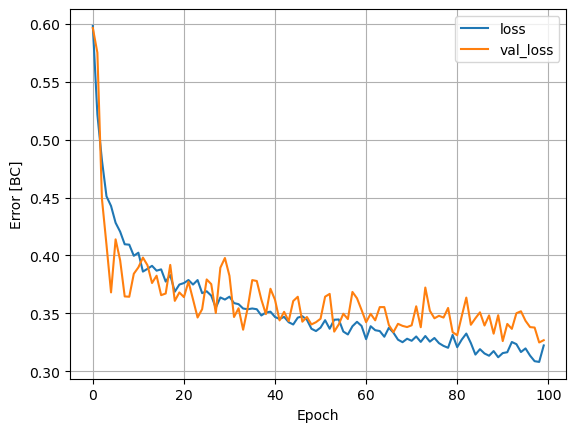

In [ ]:
plot_loss(history)

In [62]:
train_dataset.shape, test_dataset.shape

((3378, 13), (845, 14))

In [63]:
import numpy as np

def build_sequences(df, target_labels=['BC'], window=200, stride=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df) % window
    
    if padding_len != 0:
        # Compute padding length
        padding_len = window - len(df) % window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding, temp_df))
        padding = np.zeros((padding_len,1), dtype='float32')
        #padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding, temp_label))
        assert len(temp_df) % window == 0

    # Build sequences and labels
    for i in range(0, len(temp_df) - window + 1, stride):
        dataset.append(temp_df[i:i + window])
        labels.append(temp_label[i:i + window])

    return np.array(dataset), np.array(labels)

X_train, y_train = build_sequences(train_dataset, window=24, stride=24)
X_test, y_test = build_sequences(test_dataset, window=24, stride=24)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((141, 24, 13), (141, 24, 1), (36, 24, 14), (36, 24, 1))

In [67]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='linear',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
      loss=keras.losses.MeanSquaredError(),
      metrics=metrics)

  return model

In [68]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [69]:
model = make_model()
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                208       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.predict(train_features[:10])


1/1 [==============================] - 0s 11ms/step


array([[-12.623],
       [ -6.89 ],
       [ -9.783],
       [-10.47 ],
       [ -0.721],
       [-25.114],
       [ -4.592],
       [-19.121],
       [ -2.032],
       [-24.661]], dtype=float32)

In [76]:
model = make_model()


In [78]:
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_split=0.1)


Epoch 1/100
2/2 [==============================] - 1s 212ms/step - loss: 891.8610 - tp: 1924.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1116.0000 - accuracy: 3.2895e-04 - precision: 1.0000 - recall: 0.6329 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 278.8660 - val_tp: 227.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 111.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6716 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 2/100
2/2 [==============================] - 0s 21ms/step - loss: 854.8445 - tp: 1826.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1214.0000 - accuracy: 3.2895e-04 - precision: 1.0000 - recall: 0.6007 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 251.4001 - val_tp: 211.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 127.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6243 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 3/100
2/2 [==============================] - 0s 23ms/step - loss: 868.2074 - tp: 1793.000